# Import Packages

In [313]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
import glob
import math
# when you want an inline plot
%matplotlib inline
#when you want graphs in a separate window
# %matplotlib qt 

# Helper Functions

In [340]:
import math

def undistort_images(images, mtx=mtx, dist=dist):
    return cv2.undistort(images, mtx, dist, None, mtx)

def hsl_images(images):
    return cv2.cvtColor(images, cv2.COLOR_BGR2HLS)


def get_undist_imgs(images, objpoints, imgpoints):
    undist_imgs = []
    # Test undistortion on an image
    for img in images:
        img_size = (img.shape[1], img.shape[0])
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        undst = cv2.undistort(img, mtx, dist, None, mtx)
        undist_imgs.append(undst)
#         cv2.imwrite('calibration_wide/test_undist.jpg',undst)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ))
    return undist_imgs

def get_corners_imgs(images, objp):
    cor_imgs = []
    origin_imgs = []
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
#     images = glob.glob('../camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for img in images:
#         image_name, img = images_list[i]
#         img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img_corn = cv2.drawChessboardCorners(img.copy(), (9,6), corners, ret)
            cor_imgs.append(img_corn)
            original_imgs.append(img)
            img_corn = 0
    #         cv2.imshow('img',img)
    #         cv2.waitKey(500)

    # cv2.destroyAllWindows()
    return cor_imgs, objpoints, imgpoints

def show_images(images_list, imgs_names, pref="",  fig_size=(14,14), cols=5, cmap=None):
#     cols=3
#     fig_size=(15,15)
    
#     cmap = None
    num_img = len(images_list)
    r = num_img / cols
    if isinstance(r, float):
        rows = math.ceil(r)  
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < num_img:
            img = images_list[index-1]
            if cmap == None:
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(RGB_img)
            else:
                ax.imshow(img, cmap="gray")
            ax.set_title(pref + imgs_names[index-1])
            ax.axis('Off')
#     plt.figure(figsize=fig_size)
#     for i in range(num_img):
#         img = images_list[i]
#         if len(img.shape) < 3 or img.shape[-1] < 3:
#                 cmap = "gray"
#                 img = np.reshape(img, (img.shape[0], img.shape[1]))
#         plt.subplot(rows, cols, i+1)
#         plt.title(pref + imgs_names[i])
#         RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         plt.imshow(RGB_img, cmap=cmap)
#     plt.tight_layout()
#     plt.show()    

def display_images(images_list, cols = 4, rows = 5, fig_size=(14,14), cmap = None):
    num_img = len(images_list)
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < num_img:
            img_name, img = images_list[index]
            if cmap == None:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)
            ax.axis('Off')
    
def read_image(img):
    return mpimg.imread(os.path.join(img))

def save_image(images_list, caption, pref="test", folder="output_images"):
    if not os.path.exists(folder):
        os.mkdir(folder)
    for img, name in zip(images_list, caption):
        path = folder + "/" + pref + "_" + name
        Image.fromarray(img).save(path)

# Read in an Images

In [315]:
import os
path = "camera_cal/"
imgs_names = os.listdir(path)
imgs_names_path = list(map(lambda name: path + name, imgs_names))
calibrat_images = [read_image(path + name) for name in imgs_names]
# original_imgs = np.copy(all_images)

# calibrat_images = list(map(lambda image_name: (image_name, cv2.imread(image_name)), glob.glob('./camera_cal/c*.jpg')))

print(len(calibrat_images))

20


# Function used to show a list of images

20


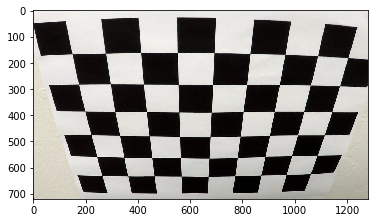

In [316]:
print(len(calibrat_images))
plt.imshow(calibrat_images[2])
# show_images(calibrat_images, imgs_names, pref="", cols=4)

# Build a Lane Finding Pipeline
<font size="3">The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</font>

# Step 1: Compute the camera calibration matrix and distortion coefficients

Corner images found: 17
Origin images found: 17


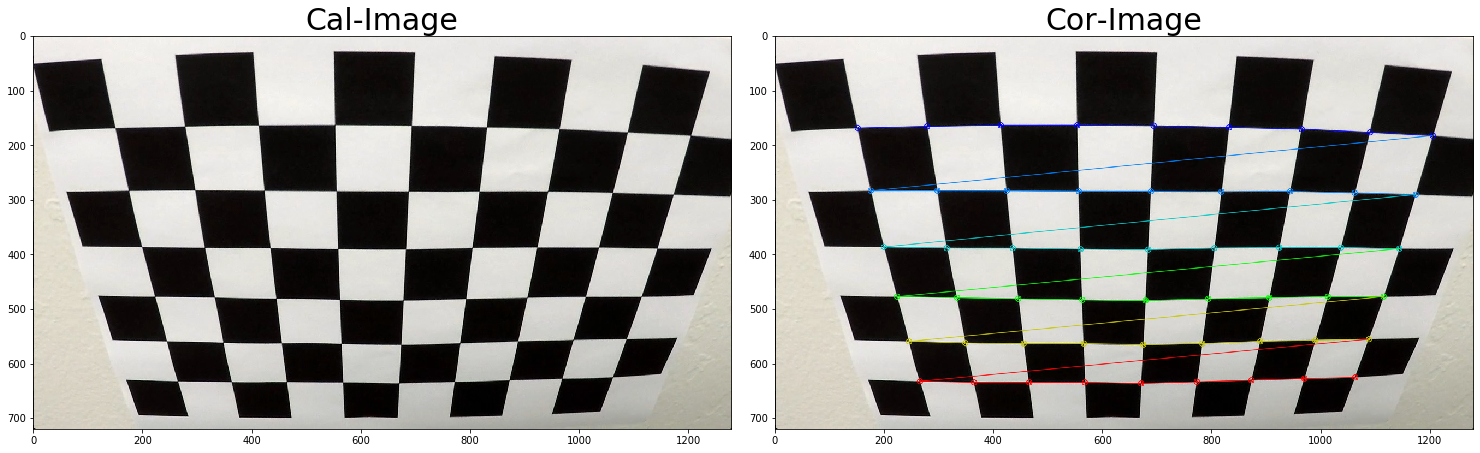

In [317]:
objpoints = []
imgpoints = []
corners_imgs = []
original_imgs = []

# print(len(cal_images))
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #that will shape coordinate back to two colomns x and y

corners_imgs, objpoints, imgpoints = get_corners_imgs(calibrat_images, objp)
# show_images(cal_imgs, imgs_names, pref="Cali_")
# Visualize undistortion
# print('Image with cr found: {}'.format(len(outimages)))
print('Corner images found: {}'.format(len(corners_imgs)))
print('Origin images found: {}'.format(len(original_imgs)))
indx =1
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout()
ax_1.imshow(original_imgs[indx]), ax_1.set_title('Cal-Image', fontsize=30)
ax_2.imshow(corners_imgs [indx]), ax_2.set_title('Cor-Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 2: Calibrate, calculate distortion coefficients, and test undistortion on images

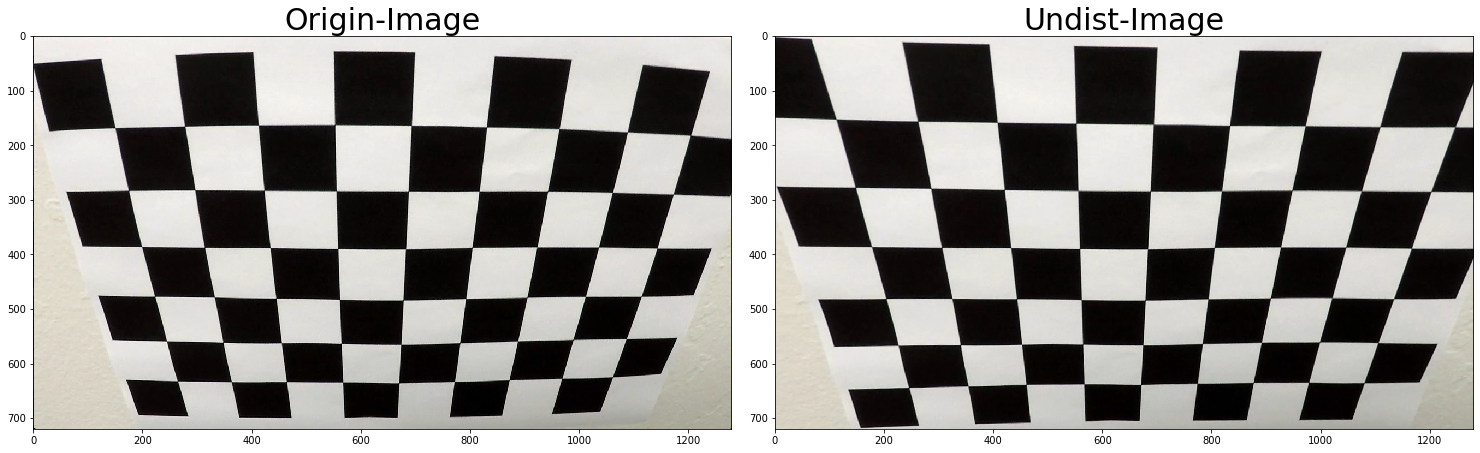

In [318]:
undist_imgs = get_undist_imgs(original_imgs, objpoints, imgpoints)
# show_images(undist_imgs, imgs_names, pref = "Undist_")
indx = 1
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout()
ax_1.imshow(original_imgs[indx]), ax_1.set_title('Origin-Image', fontsize=30)
ax_2.imshow(undist_imgs  [indx]), ax_2.set_title('Undist-Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 3: Use color transforms, gradients, etc., to create a thresholded binary image

In [319]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

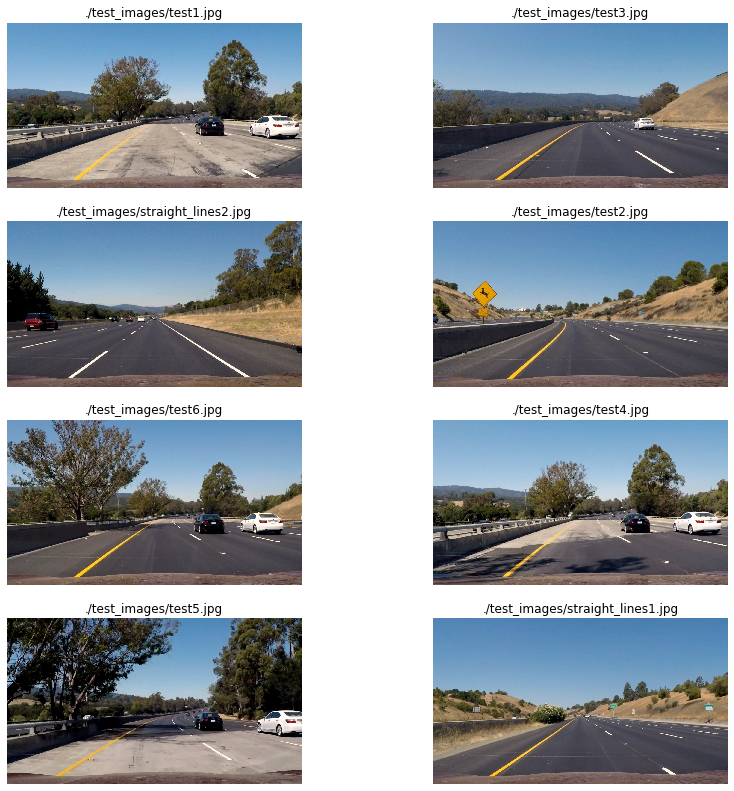

In [325]:
# Read test images with names
test_images = list(map(lambda image_file_name: (image_file_name, cv2.imread(image_file_name)), glob.glob('./test_images/*.jpg')))
# show_images(undist_imgs, imgs_names, pref = "Undist_")
display_images(list(map(lambda image: (image[0], cv2.cvtColor(image[1], cv2.COLOR_BGR2RGB)),test_images)),2, 4,)

In [328]:
import os
path = "test_images/"
org_img_names = os.listdir(path)
all_images = [read_image(path + name) for name in org_img_names]

images = glob.glob('./test_images/*.jpg')
# Step through the list and search for chessboard corners
original_images = []
original_images_names = []
for idx, fname in enumerate(images): #idx start from 0 to len(images)
    img = cv2.imread(fname)
    original_images.append(img)
    original_images_names.append(fname)

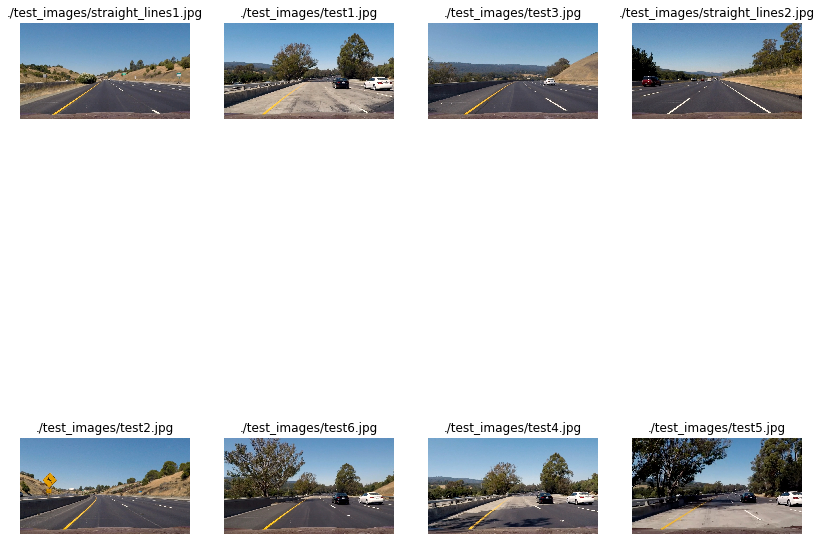

In [341]:
show_images(original_images, original_images_names, pref = "", cols = 4)

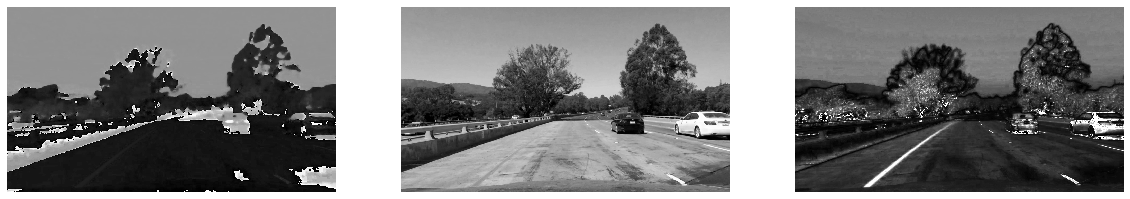

In [321]:
original_images = test_images[0][1]
# Convert images to gray and get undistort images
undist_images = undistort_images(original_images, mtx=mtx, dist=dist)
# Get HlS images 
hsl_images = hsl_images(undist_images)
# Draw h, l, s images
fig, axes = plt.subplots(ncols=3, figsize=(20,15))
for index, ax in enumerate(axes):
    ax.imshow(hsl_images[:,:,index], cmap='gray')
    ax.axis('off')